# Прогнозирование количества заражений COVID-19 в Швейцарии

## Введение. Постановка целей и задач.

В конце 2019 года было сообщено о заражениях в провинции Хубэй (Китай) коронавирусной инфекцией нового типа. За несколько месяцев этот новый вирус вызвал глобальную пандемию коронавирусной болезни (COVID-19). Несмотря на существование известных эпидемиологических моделей, ни одна из них не может с достаточной долей точности спрогнозировать ситуацию развития эпидемии COVID-19.

Целью данной работы является исследование данных о распространении COVID-19 в Швейцарии и построение краткосрочного прогноза развития пандемии в условиях непредсказуемости поведения исследуемого процесса.

Задачи, которые перед нами поставлены в данной работе:
- проведение анализа данных о распространении COVID-19 в Швейцарии;
- выявление взаимосвязей между переменными, доступными для анализа;
- подбор модели, наиболее точно предсказывающей развитие пандемии в Швейцарии.

## Импорт библиотек, ознакомление с данными.

Наша задача в данном блоке заключается в определении библиотек, функций и метрик, необходимых для работы, а также в импорте исходного датафрейма и первоначальном знакомстве с данными.

### Импорт Датафрейма, библиотек, написание функций.

In [1]:
## Загружаем pmdarima

!pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 48.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
## загружаем fbprophet

!pip install fbprophet

In [3]:
## Импортируем необходимые библиотеки и функции

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для графиков автокорреляции и частичной автокорреляции
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from statsmodels.tsa.stattools import adfuller               # для теста Дики-Фуллера
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Хольта-Винтерса
from pmdarima import auto_arima                              # для поиска ARIMA моделей
from fbprophet import Prophet                                # для модели Prophet

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error

# для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

In [4]:
## Импортируем данные

df_all = pd.read_csv('./owid-covid-data.csv')

In [5]:
## Проверяем, что данные импортировались корректно

df_all.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,0.126,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


### Знакомство с данными.

In [6]:
## Смотрим общую информацию о наших данных, обращая внимание также на тип данных

df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137176 entries, 0 to 137175
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    137176 non-null  object 
 1   continent                                   128442 non-null  object 
 2   location                                    137176 non-null  object 
 3   date                                        137176 non-null  object 
 4   total_cases                                 129550 non-null  float64
 5   new_cases                                   129545 non-null  float64
 6   new_cases_smoothed                          128505 non-null  float64
 7   total_deaths                                118273 non-null  float64
 8   new_deaths                                  118469 non-null  float64
 9   new_deaths_smoothed                         128505 non-null  float64
 

Видим, что наш исходный датайфрейм включает в себя 67 столбцов, каждый из которых несет определенную информацию, в том числе:
- date - дата наблюдения;
- location - географическое положение (страна);
- total_cases - всего подтвержденных случаев COVID-19;
- new_cases - новые подтвержденные случаи COVID-19
- total_deaths - общее количество смертей, связанных с COVID-19;
- new_deaths - новые случаи смерти, связанные с COVID-19;
- total_tests - общее количество тестов на COVID-19;
- total_vaccinations - общее количество введенных доз вакцины против COVID-19.

##### Вывод по блоку. В этом блоке мы импортировали библиотеки, функции и метрики, необходимые для нашей работы, а также познакомились с данными, которые в дальнейшем будем анализировать. Исходный датафрейм включает в себя большое количество разнообразной информации о распространении COVID-19 в мире, часть из которой мы отберем в дальнейшем для анализа.

## Предобработка данных

### Фильтрация данных

In [7]:
## Выведем список всех стран, по которым представлены данные о COVID-19

print('Количество стран, по которым представлена статистика:', df_all.location.nunique())
df_all.location.unique()

Количество стран, по которым представлена статистика: 237


array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

Видим, что наш датафрейм включает в себя данные по 237 странам. В данном исследовании мы будем рассматривать данные по Швейцарии.

In [8]:
## Для анализа в новый датасет выберем данные по Швейцарии и выберем наиболее важные столбцы, которые нам понадобятся для работы

df = df_all[df_all.location == 'Switzerland'][['date','total_cases', 'new_cases', 'total_deaths',\
                                               'new_deaths', 'total_tests', 'total_vaccinations']]

In [9]:
## Проверяем корретность нового датасета

df

,date,total_cases,new_cases,total_deaths,new_deaths,total_tests,total_vaccinations
118833,2020-02-25,1.0,1.0,NaN,NaN,NaN,NaN
118834,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN
118835,2020-02-27,8.0,7.0,NaN,NaN,NaN,NaN
118836,2020-02-28,8.0,0.0,NaN,NaN,NaN,NaN
118837,2020-02-29,18.0,10.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
119474,2021-11-27,986834.0,0.0,11470.0,0.0,12344102.0,11805235.0
119475,2021-11-28,986834.0,0.0,11471.0,1.0,12363351.0,11809935.0
119476,2021-11-29,1006239.0,19405.0,11500.0,29.0,12403612.0,11861643.0
119477,2021-11-30,1014662.0,8423.0,11522.0,22.0,NaN,11917341.0


Новый датасет включает в себя данные по Швейцарии за период с 25.02.2020 по 01.12.2021 (646 строк).

In [10]:
## Меняем тип данных по столбцу date с object на datetime

df.date = pd.to_datetime(df.date)

In [11]:
## Проверяем типы данных

df.dtypes

date                  datetime64[ns]
total_cases                  float64
new_cases                    float64
total_deaths                 float64
new_deaths                   float64
total_tests                  float64
total_vaccinations           float64
dtype: object

### Обработка пропусков

In [12]:
## Проверяем, есть ли пропуски в нашем датасете

print('Общее количество пропусков:', df.isna().sum().sum())
df.isna()

Общее количество пропусков: 410


,date,total_cases,new_cases,total_deaths,new_deaths,total_tests,total_vaccinations
118833,False,False,False,True,True,True,True
118834,False,False,False,True,True,True,True
118835,False,False,False,True,True,True,True
118836,False,False,False,True,True,True,True
118837,False,False,False,True,True,True,True
...,...,...,...,...,...,...,...
119474,False,False,False,False,False,False,False
119475,False,False,False,False,False,False,False
119476,False,False,False,False,False,False,False
119477,False,False,False,False,False,True,False


In [13]:
## Проверяем, в каких именно столбцах имеются пропуски

df_check = df.isna()

for i in df_check.columns:
    print(f'Для признака {i} пропуски: ', df_check[i].unique())

Для признака date пропуски:  [False]
Для признака total_cases пропуски:  [False]
Для признака new_cases пропуски:  [False]
Для признака total_deaths пропуски:  [ True False]
Для признака new_deaths пропуски:  [ True False]
Для признака total_tests пропуски:  [ True False]
Для признака total_vaccinations пропуски:  [ True False]


Видим, что в наших данных имеются отсутствующие значения для ряда признаков в количестве 410. Это объясняется тем, что статистика заболеваний в Швейцарии начала вестись с первых заболевших, тогда как подсчет количества смертей от COVID-19, тестирование (конец мая 2020 года) и вакцинация начались позже (конец декабря 2020 года).

In [14]:
## Заменяем отсутствующие значения на 0, чтобы не прерывать временной ряд

df = df.fillna(0)

In [15]:
## Убеждаемся в том, что пропуски в нашем датасете отсутствуют

print('Общее количество пропусков:', df.isna().sum().sum())

Общее количество пропусков: 0


##### Вывод по блоку. В данном блоке мы осуществили фильтрацию данных, а именно выбрали данные по Швейцарии и необходимые признаки в новый датасет. Установили, что наши данные содержали пропуски, которые возникли по причине добавления наблюдения ряда признаков спустя продолжительное время после первого случая заболевания в стране (данные по смертям от COVID-19,  тестированию и вакцинации), подготовили данные для дальнейшего исследования.

## EDA или разведочный анализ данных.

In [16]:
## Делаем столбец с датами индексом

df.index = df.date

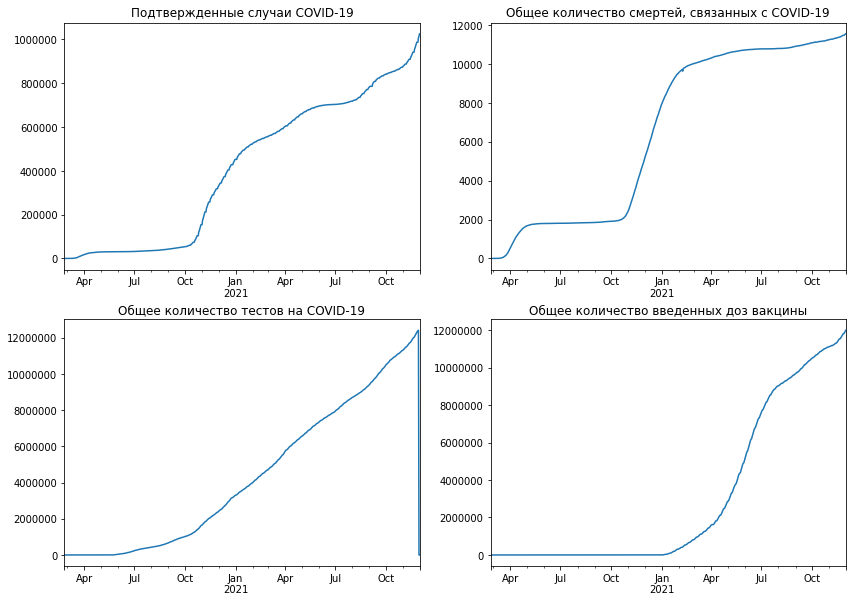

In [17]:
## Визуализируем наши данные.
## Для этого создаем сетку графиков и строим соответствующие графики. 
## Во избежании отображения научной нотации по оси y задаем параметр style.  

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

df['total_cases'].plot(ax=ax1, title='Подтвержденные случаи COVID-19', xlabel='').ticklabel_format(axis='y', style='plain')
df['total_deaths'].plot(ax=ax2, title='Общее количество смертей, связанных с COVID-19', xlabel='')
df ['total_tests'].plot(ax=ax3, title='Общее количество тестов на COVID-19', xlabel='').ticklabel_format(axis='y', style='plain')
df['total_vaccinations'].plot(ax=ax4, title='Общее количество введенных доз вакцины', xlabel='').ticklabel_format(axis='y', style='plain')

По графикам отчетливо видно, что резкий рост подтвержденных случаев и смертей, связанных с COVID-19, произошел в конце октября 2020 года. Очевидно, что на рост этих показателей повлияло увеличение охвата тестирования населения на COVID-19, а также, возможно, это связано с увеличением туристического потока, поскольку Швейцария является традиционной страной туризма. 
Кроме того, по графикам можно увидеть, что в связи с началом вакцинации в Швейцарии с января 2021 года замедлился рост смертей, связанных с COVID-19, что может говорить о том, что вакцина облегчала течение болезни и уменьшала количество смертельных случаев от вирусной инфекции.

In [18]:
## Построим матрицу корреляции признаков, округлив данные до двух знаков после запятой

df.corr().round(2)

,total_cases,new_cases,total_deaths,new_deaths,total_tests,total_vaccinations
total_cases,1.00,0.20,0.98,-0.10,0.96,0.84
new_cases,0.20,1.00,0.14,0.44,0.14,0.09
total_deaths,0.98,0.14,1.00,-0.10,0.91,0.74
new_deaths,-0.10,0.44,-0.10,1.00,-0.21,-0.32
total_tests,0.96,0.14,0.91,-0.21,1.00,0.92
total_vaccinations,0.84,0.09,0.74,-0.32,0.92,1.00


По матрице корреляции признаков видно, что между рядом признаков имеется тесная зависимость. В парах "общее количество тестов - общее количество смертей", "общее количество тестов - общее количество заболеваний", "общее количество заболеваний - общее количество смертей" наблюдается очень высокая сила связи (свыше 0,9) и можно сказать о том, что увеличение одного признака влечет за собой увеличение другого. Например, чем больше тестов проводится, тем больше выявляется в результате этого общих случаев заболевания COVID-19 и, соответственно, смертей от COVID-19.  В паре "общее количество заболеваний - общее количество введенных доз вакцины" также наблюдается высокая взаимосвязь, что можно объяснить тем, что при введении вакцины снижается иммунитет человека и он становится воспиимчивее к инфекциям, в том числе и к COVID-19. А можно интерпретировать и в обратную сторону: увеличение числа заболевших мотивирует людей на необходимость уберечь себя от заболевания путем вакцинирования.

Кроме того, интересно заметить, что между признаками "общее количество введенных доз вакцины" и "новые случаи смерти, связанные с COVID-19" имеется слабая отрицательная корреляция (-0.32), что может говорить о том, что вакцинация все же положительно влияет на иммунитет человека и уменьшает количество смертельных случаев (это мы также наблюдали на графиках выше).

Опять же стоит отметить, что наличие корреляции между признаками не всегда говорит об их причинной взаимообусловленности, то есть когда за счет эффектов одновременного влияния неучтенных факторов смысл истинной связи может искажаться.

In [19]:
## Выведем статистику по столбцам с дневными данными о новых подтвержденных случаях COVID-19 и о новых случаях смерти, 
## связанных с COVID-19, округлив данные до целых чисел.

df[['new_cases', 'new_deaths']].describe().round()

,new_cases,new_deaths
count,646.0,646.0
mean,1587.0,18.0
std,2680.0,29.0
min,0.0,-87.0
25%,17.0,1.0
50%,380.0,5.0
75%,2088.0,17.0
max,21926.0,131.0


По статистике видно, что количество новых случаев заболевания COVID-19 варьировалось от 0 до 21926 человек в день, тогда как максимальное количество смертей достигало 131 человек в день. Минимальное число смертей в день получилось -87 - отрицательное значение показателя, предположительно, связано с тем, что причина данных смертей ранее была связана с COVID-19, а в дальнейшем была отнесена к смерти по иным причинам, в связи с чем была произведена корректировка. В среднем число новых выявленных заболеваний и число смертей составило 1587 и 18 человек в день соответственно.

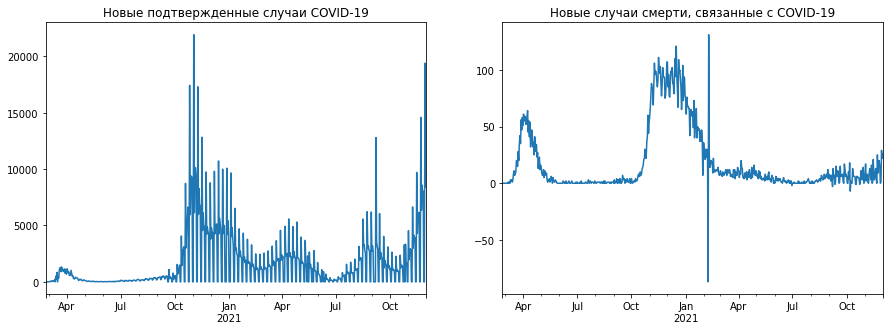

In [20]:
## Визуализируем наши данные, построив дневные графики по числу новых подтвержденных случаев заболевания и количеству смертей. 

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

df['new_cases'].plot(ax=ax1, title='Новые подтвержденные случаи COVID-19', xlabel='')
df['new_deaths'].plot(ax=ax2, title='Новые случаи смерти, связанные с COVID-19', xlabel='');

На дневном графике новых подтвержденных случаев COVID-19 отчетливо видно, что максимальное количество выявленных заболевших в день приходилось на конец октября 2020 года, минимальное количество после значительного роста - в июле 2021 года. С конца ноября 2021 года вновь видим значительное увеличение количества новых случаев заболевания в день, что опять же, предположительно, можно объяснить возросшим туристическим потоком. Таким образом, на графике вырисовывается некая закономерность, выявить которую мы попробуем в дальнейшем.

На дневном графике новых случаев смерти, связанных с COVID-19, видно, что в феврале 2021 года были выбросы в данных - как в сторону увеличения, так и в сторону уменьшения. Предположительно это связано с тем, что ряд случаев смерти первоначально был засчитан как смерть, связанная с COVID-19 (что объясняет выброс в сторону увеличения), а затем отнесен к смерти по иным причинам (что объясняет выброс в -87, который мы установили ранее по статистике). Какой-либо закономерности в смертях в данном случае на графике мы не наблюдаем.

##### Вывод по блоку. В данном блоке мы подробно ознакомились с исследуемыми данными по заболеваемости COVID-19 в Швейцарии, сделали предположения о возможной взаимосвязи между признаками, а также посмотрели статистику по количеству новых случаев заболевания COVID-19 и о новых случаях смерти, связанной с этим заболеванием.

## Построение моделей, анализ результатов.

### Проверка ряда на стационарность

Стационарный временной ряд - это тот, для которого свойства (а именно среднее значение, дисперсия и ковариация) не зависят от времени. Прогнозирование по нестационарному временному ряду значительно усложняется и результат может не оправдать ожиданий, поэтому как правило перед построением прогноза ряд приводится к стационарному.

Для проверки нашего временного ряда на стационарность будем использовать тест Дики-Фуллера.

Выдвигается гипотеза $H_0$ о наличии единичного корня, который как раз и свидетельствует о нестационарности ряда. Если $t_{расч.} > t_{крит.}$ на всех уровнях значимости, то гипотеза $H_0$ подтверждается.

In [21]:
## Запускаем тест Дики-Фуллера.

adfuller(df.new_cases)

(-2.3422986780966286,
 0.1586883516201179,
 14,
 631,
 {'1%': -3.440755866431696,
  '10%': -2.569215089800357,
  '5%': -2.86613130039063},
 10522.238633996434)

В результате выполнения получили следующие значения:
- -2.34 - значение $t_{расч.}$;
- 0.16 - значение pvalue;
- 14 - количество использованных лагов;
- 631 - количество наблюдений, используемых для регрессии ADF и расчета критических значений;
- -3.44, -2.87, -2.57 - критические значения для статистики теста на уровнях 1%, 5% и 10% соответственно;
- 10522.24 - максимальный информационный критерий.


Поскольку $t_{расч.} > t_{крит.}$ на всех уровнях значимости ($-2.34 > -2.57 > -2.87 > -3.44$), то рассматриваемый временной ряд является нестационарным. Таким образом, нулевая гипотеза $H_0$ о наличии единичного корня подтверждается.

### Построение графиков автокорреляции и частичной автокорреляции

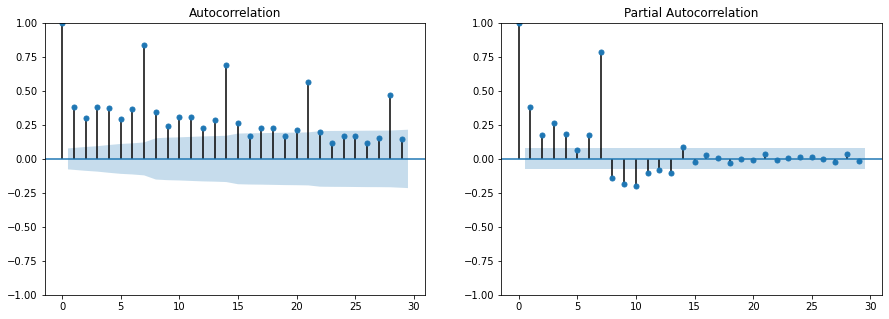

In [22]:
# Построим графики автокорреляции и частичной автокорреляции нашего временного ряда.

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

plot_acf(df.new_cases, ax=ax1);
plot_pacf(df.new_cases, ax=ax2);

По графику автокорреляции можно заметить, что элементы коррелограммы убывают линейно. Это говорит о том, что временной ряд имеет "долговременную память" и присущие ему свойства и закономерности могут быть с успехом экстраполированы в будущем. Значимый коэффициент корреляции для лагов 7, 14, 21 и 28 намекает на недельную цикличность.

График частичной автокорреляции характеризуется резко выделяющимся значением на седьмом лаге, что также говорит о возможной недельной цикличности.

### ETS декомпозиция

Чтобы лучше понять данные, с которыми мы работаем, проведем ETS декомпозицию, а именно разложим исходный ряд данных на составляющие: тренд, сезонная компонента и случайная компонента (остаток).

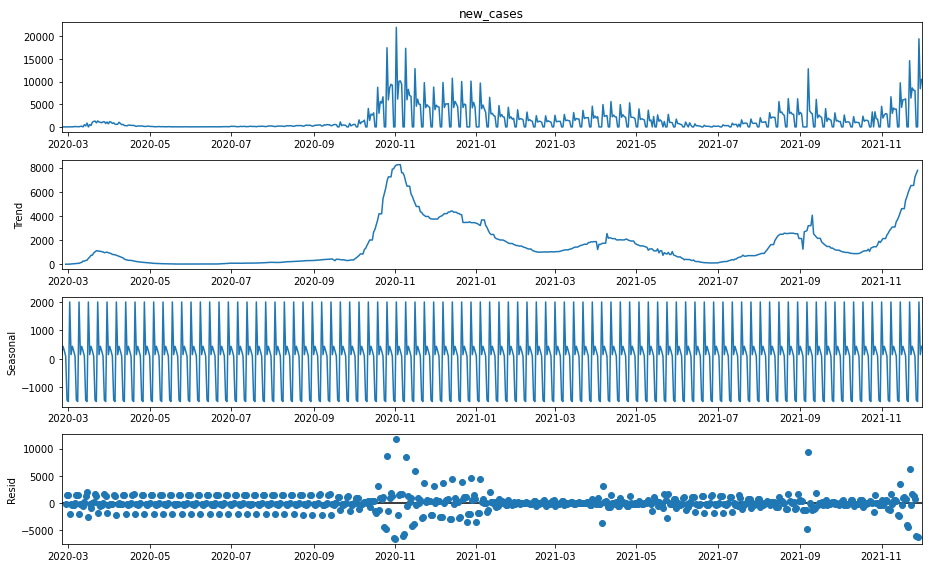

In [23]:
## Проведем ETS декомпозицию, задав предварительно параметры фигуры для вывода графиков большего масштаба

plt.rcParams['figure.figsize'] = (13, 8)
r = seasonal_decompose(df['new_cases'],model='additive')
r.plot();

### Разделение датасета

Разделим наш датасет на тренировочную и тестовую выборки, которые соответственно будут использоваться в дальнейшем для непосредственного обучения модели и для оценки ее качества.

В нашем случае горизонт планирования сделаем небольшим и в качестве тестовой выборки возьмем 10 последних наблюдений.

In [24]:
## Разделяем наш датасет на тренировочную и тестовую выборки

train = df.iloc[:len(df)-10]
test = df.iloc[len(df)-10:]

### Прогнозирование с помощью модели SARIMA

Для прогнозирования данных построим модель авторегрессионного интегрированного скользящего среднего с учетом сезонности (SARIMA). Приводить ряд к стационарному перед применением модели не будем, поскольку модель уже включается в себя интегрирующий член I, который как раз и приводит ряд к стационарному путем взятия разностей порядка d. В результате должны получить параметры модели (p, d, q)x(P, D, Q, m), где:
- p - порядок авторегрессии тренда;
- d - порядок изменения тренда;
- q - тренд скользящей средней;
- P - сезонный порядок авторегрессии;
- D - порядок сезонных разниц;
- Q - сезонный порядок скользящих средних;
- m - количество временных шагов за один сезонный период.

Построение модели будем производить с помощью функции auto_arima, которая в качестве входных данных принимает одномерный временной ряд и использует алгоритм, который объединяет тесты для подбора лучшей модели ARIMA. Для получения модели SARIMA мы укажем в параметрах учет сезонности.

In [25]:
## Строим модель SARIMA, задав количество временных шагов за один сезонный период равным 7 (недельная сезонность).

auto_arima(df['new_cases'],seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  646
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 7)   Log Likelihood               -5433.079
Date:                            Wed, 22 Dec 2021   AIC                          10874.157
Time:                                    17:50:21   BIC                          10892.034
Sample:                                         0   HQIC                         10881.094
                                            - 646                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0675      0.018    -58.518      0.000      -1.103      -1.032
ma.L2          0.2522      0.018     14.167      0.000       0.217       0.287
ar.S.L7        0.9048      0.008    119.840      0.000       0.890       0.920
sigma2      1.193e+06    2.5e+04     47.805      0.000    1.14e+06    1.24e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             24327.44
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              58.27   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Получили следующие оптимальные параметры нашей модели: (0, 1, 2)x(1, 0, [], 7).

Значения AIC (Akaike Information Criterion) и BIC (Bayesian Information Criterion) являются оценками для сравнения моделей. Чем ниже эти значения, тем лучше модель.

In [26]:
# Обучаем модель на полученных оптимальных параметрах: (0, 1, 2)x(1, 0, [], 7)

model_sarima = SARIMAX(train['new_cases'],order=(0, 1, 2),seasonal_order=(1, 0, [], 7))
results_sarima = model_sarima.fit()
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  636
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 7)   Log Likelihood               -5330.457
Date:                            Wed, 22 Dec 2021   AIC                          10668.913
Time:                                    17:50:58   BIC                          10686.728
Sample:                                02-25-2020   HQIC                         10675.830
                                     - 11-21-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0602      0.018    -58.882      0.000      -1.095      -1.025
ma.L2          0.2469      0.017     14.123      0.000       0.213       0.281
ar.S.L7        0.8683      0.008    114.748      0.000       0.854       0.883
sigma2      1.129e+06   2.29e+04     49.222      0.000    1.08e+06    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             28145.09
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              52.77   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        35.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
## Получаем прогнозируемые значения

start=len(train)
end=len(train)+len(test)-1
predictions_sarima = results_sarima.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions SARIMA(0, 1, 2)x(1, 0, [], 7)')

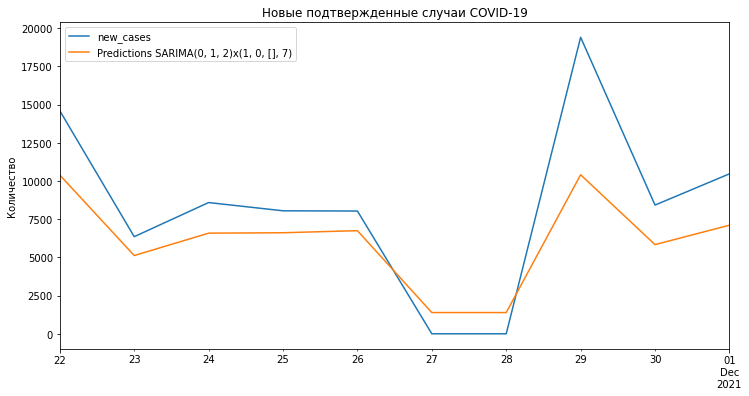

In [28]:
## Нарисуем графики прогнозируемых и известных значений

test['new_cases'].plot(title = 'Новые подтвержденные случаи COVID-19', xlabel = '', ylabel = 'Количество', legend=True,  figsize=(12,6))
predictions_sarima.plot(legend=True);

In [29]:
## Оценим качество модели с помощью MSE и RMSE

error1 = mean_squared_error(test['new_cases'], predictions_sarima)
error2 = rmse(test['new_cases'], predictions_sarima)
print(f'SARIMAX(0, 1, 2)x(1, 0, [], 7) MSE Error: {error1:11.10}')
print(f'SARIMAX(0, 1, 2)x(1, 0, [], 7) RMSE Error: {error2:11.10}')

SARIMAX(0, 1, 2)x(1, 0, [], 7) MSE Error: 12975166.28
SARIMAX(0, 1, 2)x(1, 0, [], 7) RMSE Error: 3602.105812


Среднеквадратичная ошибка, полученная по модели SARIMA,составила 3602, таким образом прогноз примерно на 3600 случаев отклоняется от истинных значений заболеваемости в день. Стоит отметить, что мы не вычисляли среднюю абсолютную процентную ошибку (MAPE), поскольку когда в наблюдаемых значениях ряда имеются нулевые значения, MAPE не может быть использована в качестве меры оценки модели (получаем значение inf).

In [30]:
## Тренируем модель на полном датасете

fut_model_sarima = SARIMAX(df['new_cases'],order=(0, 1, 2),seasonal_order=(1, 0, [], 7))
fut_results_sarima = fut_model_sarima.fit()
fut_results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          new_cases   No. Observations:                  646
Model:             SARIMAX(0, 1, 2)x(1, 0, [], 7)   Log Likelihood               -5433.079
Date:                            Wed, 22 Dec 2021   AIC                          10874.157
Time:                                    17:51:29   BIC                          10892.034
Sample:                                02-25-2020   HQIC                         10881.094
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0675      0.018    -58.518      0.000      -1.103      -1.032
ma.L2          0.2522      0.018     14.167      0.000       0.217       0.287
ar.S.L7        0.9048      0.008    119.840      0.000       0.890       0.920
sigma2      1.193e+06    2.5e+04     47.805      0.000    1.14e+06    1.24e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             24327.44
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):              58.27   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
##  Предсказываем на 10 дней вперед

fut_fcast_sarima = fut_results_sarima.predict(len(df)-1,len(df)+9,typ='levels').rename('Predictions SARIMA(0, 1, 2)x(1, 0, [], 7)')

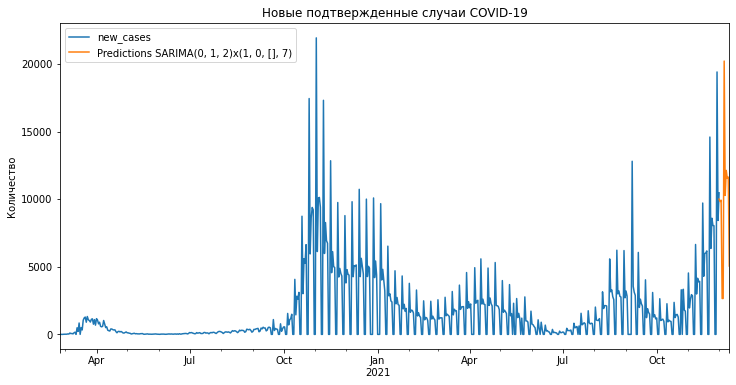

In [32]:
## Нарисуем графики прогнозируемых и известных значений

df['new_cases'].plot(title = 'Новые подтвержденные случаи COVID-19', xlabel = '', ylabel = 'Количество', legend=True,  figsize=(12,6))
fut_fcast_sarima.plot(legend=True);

Можно сделать вывод, что модель SARIMA достаточно неплохо показала себя на наших данных, дав предсказание на тестовой выборке в ряде случаев близкие к реальным данным, однако имелись и значительные расхождения, о чем говорит значение среднеквадратичной ошибки в количестве 3602 случаев. Причиной в данном случае можно назвать наличие ряда других признаков, которые оказывают влияние на количество возникновения новых случаев заболевания и которые не учитываются в нашей модели (зависимость скорости распространения инфекции от плотности населения, индекса самоизоляции, соблюдения мер безопасности и прочих факторов).

### Прогнозирование с помощью модели Хольта-Винтерса

Модель Хольта-Винтерса предусматривает тройное экспоненциальное сглаживание - это расширение экспоненциального сглаживания, которое явно добавляет поддержку сезонности в одномерный временной ряд. Тройное экспоненциальное сглаживание может быть реализовано в Python с помощью класса ExponentialSmoothing Statsmodels.

In [33]:
## Строим модель Хольта-Винтерса на тренировочной выборке, задав количество временных шагов в сезонном периоде равным 7 (недельная сезонность)

model_holt = ExponentialSmoothing(train['new_cases'], trend='add', seasonal = 'add', seasonal_periods=7).fit()

In [34]:
## Выведем параметры получившейся модели Хольта-Винтерса

print(model_holt.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                new_cases   No. Observations:                  636
Model:             ExponentialSmoothing   SSE                      772106912.596
Optimized:                         True   AIC                           8932.001
Trend:                         Additive   BIC                           8981.008
Seasonal:                      Additive   AICC                          8932.586
Seasonal Periods:                     7   Date:                 Wed, 22 Dec 2021
Box-Cox:                          False   Time:                         17:51:47
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1110714                alpha                 True
smoothing_trend          

In [35]:
## Получаем прогнозируемые значения

start=len(train)
end=len(train)+len(test)-1
predictions_holt = model_holt.predict(start=start, end=end).rename('Holt-Winters')

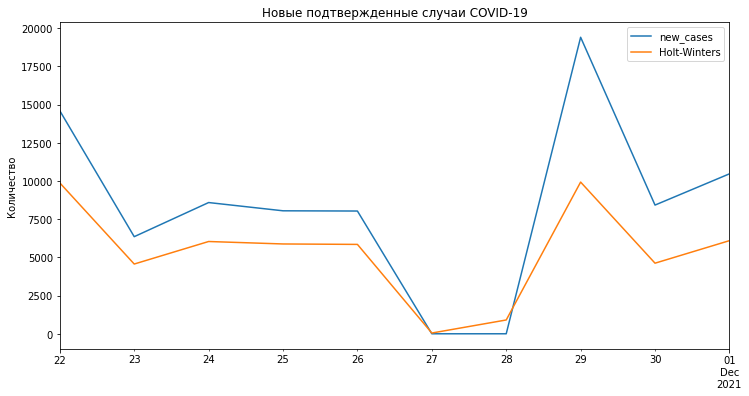

In [36]:
## Нарисуем графики прогнозируемых и известных значений

test['new_cases'].plot(title = 'Новые подтвержденные случаи COVID-19', xlabel = '', ylabel = 'Количество', legend=True,  figsize=(12,6))
predictions_holt.plot(legend=True);

In [37]:
## Оценим качество модели с помощью MSE и RMSE

error1 = mean_squared_error(test['new_cases'], predictions_holt)
error2 = rmse(test['new_cases'], predictions_holt)
print(f'Holt-Winters MSE Error: {error1:11.10}')
print(f'Holt-Winters RMSE Error: {error2:11.10}')

Holt-Winters MSE Error: 16568926.11
Holt-Winters RMSE Error: 4070.494578


In [38]:
## Строим модель Хольта-Винтерса на полном датасете

fut_model_holt = ExponentialSmoothing(df['new_cases'], trend='add', seasonal = 'add', seasonal_periods=7).fit()

In [39]:
## Выведем параметры получившейся модели Хольта-Винтерса

print(fut_model_holt.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                new_cases   No. Observations:                  646
Model:             ExponentialSmoothing   SSE                      816547307.593
Optimized:                         True   AIC                           9098.168
Trend:                         Additive   BIC                           9147.347
Seasonal:                      Additive   AICC                          9098.744
Seasonal Periods:                     7   Date:                 Wed, 22 Dec 2021
Box-Cox:                          False   Time:                         17:52:01
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1110714                alpha                 True
smoothing_trend          

In [40]:
## Получаем прогнозируемые значения

fut_predictions_holt = fut_model_holt.predict(len(df)-1,len(df)+9).rename('Holt-Winters')

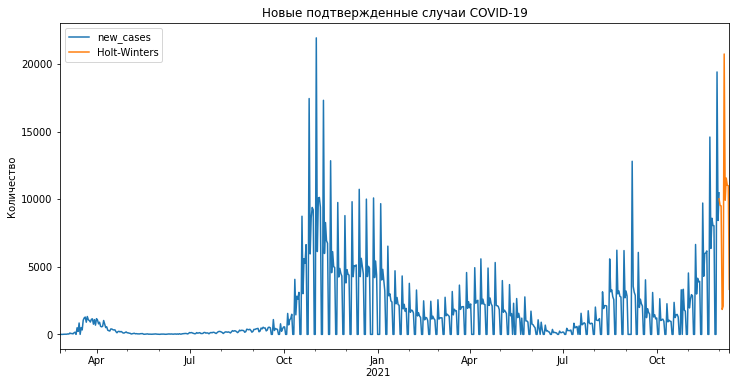

In [41]:
## Нарисуем графики прогнозируемых и известных значений

df['new_cases'].plot(title = 'Новые подтвержденные случаи COVID-19', xlabel = '', ylabel = 'Количество', legend=True,  figsize=(12,6))
fut_predictions_holt.plot(legend=True);

Можно сделать вывод, что модель Хольта-Винтерса достаточно неплохо показала себя на наших данных, дав предсказание на тестовой выборке в ряде случаев близкие к реальным данным, однако имелись и значительные расхождения, о чем говорит значение среднеквадратичной ошибки в количестве порядка 4000 случаев. Причиной в данном случае можно назвать наличие ряда других признаков, которые оказывают влияние на количество возникновения новых случаев заболевания и которые не учитываются в нашей модели, а также на то, что мы не приводили ряд к стационарному перед построением модели, что могло также сказаться на ухудшении прогнозирования.

### Прогнозирование с помощью модели PROPHET

В основе модели Prophet лежит процедура подгонки аддитивных регрессионных моделей со следующими четырьмя основными компонентами: тренд, сезонность, аномальные дни(праздники) и ошибки (содержит информацию, которая не учтена моделью).

In [42]:
## Разделяем наш датасет на тренировочную и тестовую выборки

train_prophet = train[['date','new_cases']]
test_prophet = test[['date','new_cases']]

In [43]:
## Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet

train_prophet.columns = ['ds', 'y']
test_prophet.columns = ['ds', 'y']

In [44]:
## Подготовим данные по всему датасету для модели

df_prophet = df[['date','new_cases']]
df_prophet.columns = ['ds', 'y']

In [45]:
## Создаем модель с подобранными параметрами

model_prophet = Prophet(seasonality_mode='multiplicative')

In [46]:
## Обучаем модель на обучающей выборке

model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


При построении модели не была найдена годовая и ежедневная сезонность, зато была установлена еженедельная сезонность, что подтверждает наши выводы, полученные ранее.

In [47]:
## Создаем датафрейм на 10 дней вперед

future_prophet = model_prophet.make_future_dataframe(periods=10)

In [48]:
## Получаем прогнозируемые значения

prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-02-25,212.454451,-1438.460283,1755.568614,212.454451,212.454451,0.021831,0.021831,0.021831,0.021831,0.021831,0.021831,0.0,0.0,0.0,217.092511
1,2020-02-26,211.024453,-1331.598326,1955.436282,211.024453,211.024453,0.312195,0.312195,0.312195,0.312195,0.312195,0.312195,0.0,0.0,0.0,276.905127
2,2020-02-27,209.594454,-1282.341633,1857.593180,209.594454,209.594454,0.198959,0.198959,0.198959,0.198959,0.198959,0.198959,0.0,0.0,0.0,251.295174
3,2020-02-28,208.164455,-1391.210656,1865.592169,208.164455,208.164455,0.073369,0.073369,0.073369,0.073369,0.073369,0.073369,0.0,0.0,0.0,223.437262
4,2020-02-29,206.734456,-1650.001448,1554.427030,206.734456,206.734456,-1.090262,-1.090262,-1.090262,-1.090262,-1.090262,-1.090262,0.0,0.0,0.0,-18.660312


In [49]:
## Устанавливаем индекс и проверяем изменения

prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-02-25,2020-02-25,212.454451,-1438.460283,1755.568614,212.454451,212.454451,0.021831,0.021831,0.021831,0.021831,0.021831,0.021831,0.0,0.0,0.0,217.092511
2020-02-26,2020-02-26,211.024453,-1331.598326,1955.436282,211.024453,211.024453,0.312195,0.312195,0.312195,0.312195,0.312195,0.312195,0.0,0.0,0.0,276.905127
2020-02-27,2020-02-27,209.594454,-1282.341633,1857.593180,209.594454,209.594454,0.198959,0.198959,0.198959,0.198959,0.198959,0.198959,0.0,0.0,0.0,251.295174
2020-02-28,2020-02-28,208.164455,-1391.210656,1865.592169,208.164455,208.164455,0.073369,0.073369,0.073369,0.073369,0.073369,0.073369,0.0,0.0,0.0,223.437262
2020-02-29,2020-02-29,206.734456,-1650.001448,1554.427030,206.734456,206.734456,-1.090262,-1.090262,-1.090262,-1.090262,-1.090262,-1.090262,0.0,0.0,0.0,-18.660312


In [50]:
## Оставляем только необходимые столбцы

prediction_prophet[['ds', 'yhat']]

,ds,yhat
ds,,
2020-02-25,2020-02-25,217.092511
2020-02-26,2020-02-26,276.905127
2020-02-27,2020-02-27,251.295174
2020-02-28,2020-02-28,223.437262
2020-02-29,2020-02-29,-18.660312
...,...,...
2021-11-27,2021-11-27,-223.931421
2021-11-28,2021-11-28,-237.441899
2021-11-29,2021-11-29,6460.761856


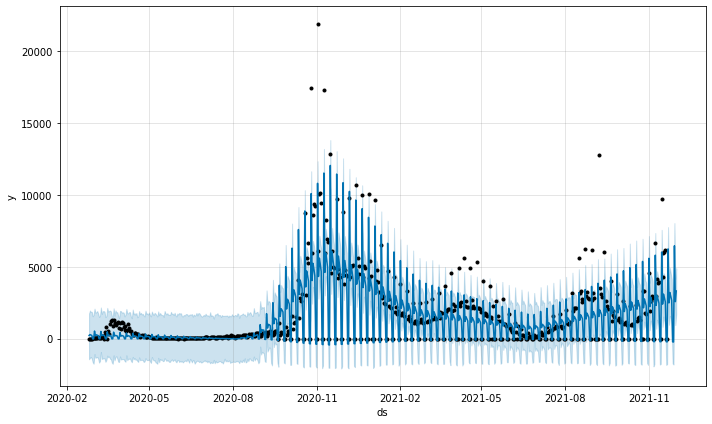

In [51]:
## Нарисуем графики прогнозируемых и известных значений

model_prophet.plot(prediction_prophet);

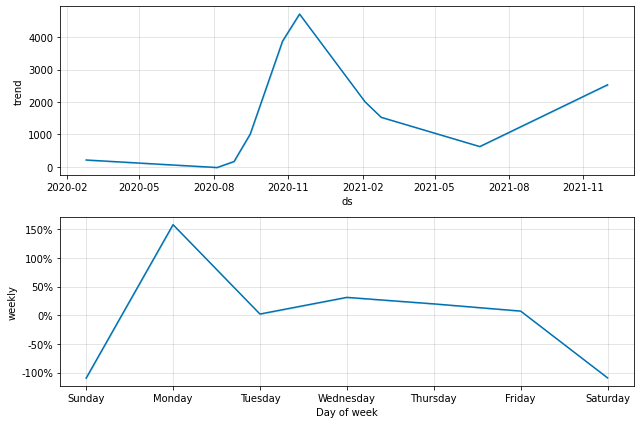

In [52]:
## Раскладываем ряд на тренд и сезонность

model_prophet.plot_components(prediction_prophet);

По графику видно, что повышение количества выявленных заболеваний приходится на понедельник и снижается на выходных, что вполне объянимо тем, что заболевшие обращались в медицинские учреждения в будние дни больше, чем в выходные.

In [53]:
## Оценим качество модели с помощью MSE и RMSE

error1 = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
error2 = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(10))

print(f'Prophet MSE Error: {error1:11.10}')
print(f'Prophet RMSE Error: {error2:11.10}')

Prophet MSE Error: 42162058.85
Prophet RMSE Error: 6493.231772


In [54]:
## Обучаем модель на полном датасете

fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_prophet)

## Создаем датафрейм на 10 дней вперед

fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


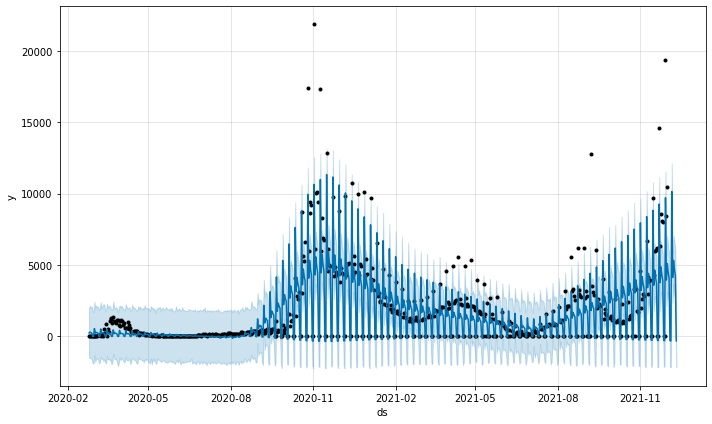

In [55]:
## Нарисуем графики прогнозируемых и известных значений

fut_model_prophet.plot(fut_fcast_prophet);

In [56]:
## Устанавливаем индекс и проверяем изменения

fut_fcast_prophet.index = fut_fcast_prophet.ds
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-02-25,2020-02-25,218.911259,-1512.569617,1999.027337,218.911259,218.911259,0.037366,0.037366,0.037366,0.037366,0.037366,0.037366,0.0,0.0,0.0,227.091161
2020-02-26,2020-02-26,217.177860,-1547.312771,2141.164450,217.177860,217.177860,0.332655,0.332655,0.332655,0.332655,0.332655,0.332655,0.0,0.0,0.0,289.423238
2020-02-27,2020-02-27,215.444461,-1547.517936,1976.309929,215.444461,215.444461,0.165159,0.165159,0.165159,0.165159,0.165159,0.165159,0.0,0.0,0.0,251.026967
2020-02-28,2020-02-28,213.711062,-1588.631462,2105.317098,213.711062,213.711062,0.052762,0.052762,0.052762,0.052762,0.052762,0.052762,0.0,0.0,0.0,224.986816
2020-02-29,2020-02-29,211.977663,-1879.567061,1777.430079,211.977663,211.977663,-1.080466,-1.080466,-1.080466,-1.080466,-1.080466,-1.080466,0.0,0.0,0.0,-17.056993


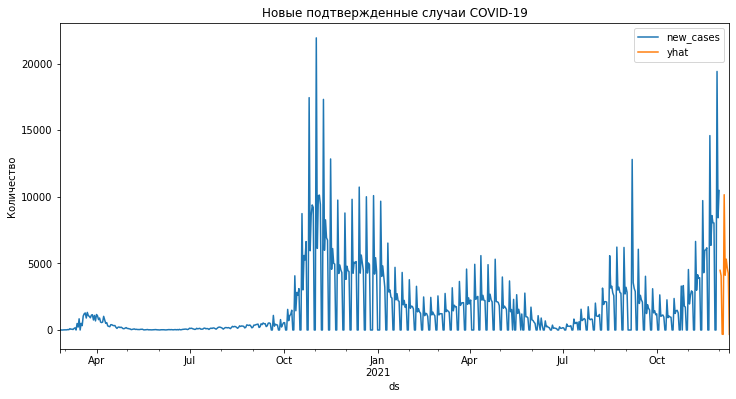

In [57]:
## Нарисуем графики прогнозируемых и известных значений

df['new_cases'].plot(title = 'Новые подтвержденные случаи COVID-19', xlabel = '', ylabel = 'Количество', legend=True,  figsize=(12,6))
fut_fcast_prophet['yhat'].tail(10).plot(legend=True);

Модель PROPHET показала себя на наших данных хуже всех (значение среднеквадратичной ошибки в количестве 6493 случаев), однако дала более подробное представление о еженедельной сезонности.

##### Вывод по блоку. В данном блоке мы провели довольно обширную работу по декомпозиции нашего временного ряда, разделяли выборки на обучающую и тестовую выборки, а также рассмотрели применение трех моделей для прогнозирования возникновения новых случаев заболевания COVID-19 в Швейцарии. Все модели показали оптимальные результаты при задании параметра недельной сезонности, которую мы наблюдаем в данных. Наилучший результат показала модель SARIMA, построив модель с наименьшей среднеквадратичной ошибкой. Можно сделать предположение, что низкое качество прогноза обусловлено наличием ряда других признаков, которые оказывают влияние на количество возникновения новых случаев заболевания и которые не были учтены в наших моделях (зависимость скорости распространения инфекции от плотности населения, индекса самоизоляции, соблюдения мер безопасности и прочих факторов).

## Выводы

Исходя из проведенной работы можно сделать вывод, что требуется разработка новых подходов к моделированию и прогнозированию временных рядов в условиях непредсказуемости поведения исследуемого процесса. Говорить о построении модели, которая адекватно описывала бы процесс распространения коронавирусной инфекции, в настоящий момент преждевременно, поскольку прошло мало времени с начала пандемии, нет возможности оценить возможный сезонный характер данных (например, годовую сезонность). Однако на примере данных Швейцарии мы получили результат, который говорит о том, что из трех рассмотренных моделей наилучшим образом для прогнозирования подошла модель SARIMA с установленным параметром еженедельной сезонности. 

В прогнозах, представленных на 10 дней, по выявлению новых случаев COVID-19 можно усмотреть тенденцию на возрастание, таким образом можно сказать что повторяется ситуация прошлого года, когда был зафиксирован резкий скачок числа заболеваний, приходящийся на рождественские праздники и рост числа туристов в Швейцарии. При этом он будет не такой значительный, поскольку активно проводится иммунизация населения.

В качестве направлений дальнейших исследований можно рассматривать изучение и выявление особенностей других моделей прогнозирования временных рядов, в том числе учитывающих какие-либо дополнительные параметры, которые влияют на распространение заболевания на территории Швейцарии.